In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.dml import CausalForestDML
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

/Users/ashishdate/Documents/IITJ/4th year/Assignment 4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('sim_health.csv')
print(f'Dataset shape: {df.shape}')
print(f'Treatment distribution: {df["D"].value_counts().to_dict()}')

Dataset shape: (1000, 93)
Treatment distribution: {1: 513, 0: 487}


In [7]:
Y = df['Y'].values
D = df['D'].values
X_cols = [col for col in df.columns if col not in ['Y', 'D']]

# Encode categorical variables
df_X = df[X_cols].copy()
for col in df_X.select_dtypes(include=['object']).columns:
    df_X[col] = pd.Categorical(df_X[col]).codes

X = df_X.values

## 1. Double-LASSO with Cross-Fitting

In [5]:
def double_lasso_dml(Y, D, X, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    theta_folds = []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        D_train, D_test = D[train_idx], D[test_idx]
        
        lasso_y = LassoCV(cv=5, random_state=42, max_iter=5000)
        lasso_y.fit(X_train, Y_train)
        Y_res = Y_test - lasso_y.predict(X_test)
        
        lasso_d = LassoCV(cv=5, random_state=42, max_iter=5000)
        lasso_d.fit(X_train, D_train)
        D_res = D_test - lasso_d.predict(X_test)
        
        theta = np.sum(D_res * Y_res) / np.sum(D_res * D_res)
        theta_folds.append(theta)
    
    theta_hat = np.mean(theta_folds)
    theta_se = np.std(theta_folds) / np.sqrt(n_folds)
    
    return theta_hat, theta_se, theta_folds

In [8]:
ate_dl, se_dl, folds_dl = double_lasso_dml(Y, D, X)
ci_lower_dl = ate_dl - 1.96 * se_dl
ci_upper_dl = ate_dl + 1.96 * se_dl

print(f'Double-LASSO ATE: {ate_dl:.4f}')
print(f'Standard Error: {se_dl:.4f}')
print(f'95% CI: [{ci_lower_dl:.4f}, {ci_upper_dl:.4f}]')

Double-LASSO ATE: 1.1111
Standard Error: 0.1170
95% CI: [0.8817, 1.3405]


## 2. Causal Forest

In [10]:
cf_model = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=100, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, random_state=42),
    n_estimators=1000,
    min_samples_leaf=5,
    max_depth=10,
    random_state=42,
    cv=5
)

cf_model.fit(Y, D, X=X, W=None)
ate_cf = cf_model.ate(X)
ate_inf_cf = cf_model.ate_inference(X)

ci_cf = ate_inf_cf.conf_int_mean()
print(f'Causal Forest ATE: {ate_cf:.4f}')
print(f'95% CI: [{ci_cf[0]:.4f}, {ci_cf[1]:.4f}]')

Causal Forest ATE: 0.9581
95% CI: [0.6057, 1.3106]


In [11]:
cate = cf_model.effect(X)
print(f'CATE range: [{cate.min():.4f}, {cate.max():.4f}]')
print(f'CATE std: {cate.std():.4f}')

CATE range: [0.4670, 1.3550]
CATE std: 0.0910


### ATE Comparison

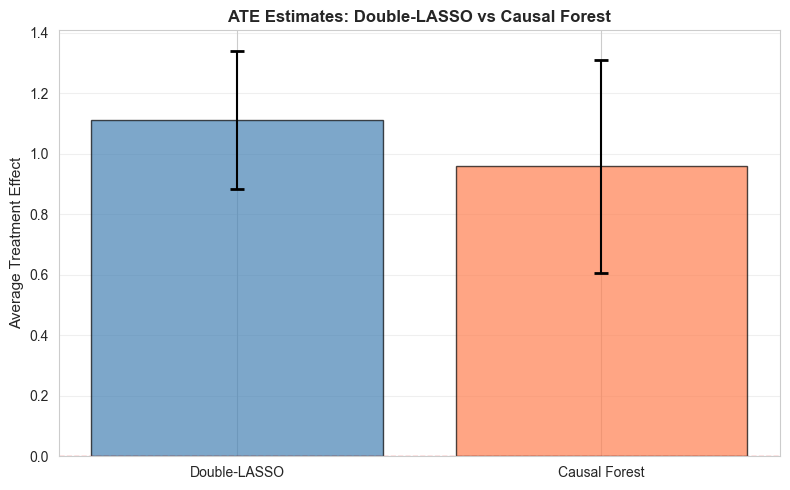

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
methods = ['Double-LASSO', 'Causal Forest']
ates = [ate_dl, ate_cf]
errors = [se_dl * 1.96, (ci_cf[1] - ate_cf)]

ax.bar(methods, ates, color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
ax.errorbar(methods, ates, yerr=errors, fmt='none', color='black', capsize=5, capthick=2)
ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax.set_ylabel('Average Treatment Effect', fontsize=11)
ax.set_title('ATE Estimates: Double-LASSO vs Causal Forest', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('ate_comparison.png', bbox_inches='tight')
plt.show()

### CATE by Region

In [14]:
df['CATE'] = cate
region_cate = df.groupby('region')['CATE'].agg(['mean', 'std', 'count']).reset_index()
region_cate['se'] = region_cate['std'] / np.sqrt(region_cate['count'])
region_cate = region_cate.sort_values('mean')

print('CATE by Region:')
print(region_cate[['region', 'mean', 'se']].to_string(index=False))

CATE by Region:
 region     mean       se
  South 0.940714 0.007869
  North 0.952253 0.006027
   West 0.958681 0.006065
Central 0.968948 0.006216
   East 0.970091 0.005616


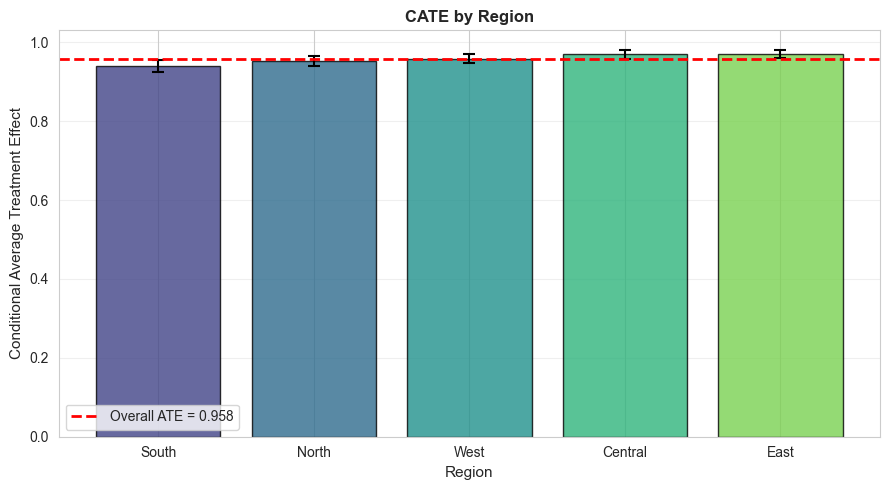

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(region_cate)))
bars = ax.bar(region_cate['region'], region_cate['mean'], color=colors, alpha=0.8, edgecolor='black')
ax.errorbar(region_cate['region'], region_cate['mean'], yerr=region_cate['se']*1.96, 
            fmt='none', color='black', capsize=4, capthick=1.5)
ax.axhline(ate_cf, color='red', linestyle='--', linewidth=2, label=f'Overall ATE = {ate_cf:.3f}')
ax.set_xlabel('Region', fontsize=11)
ax.set_ylabel('Conditional Average Treatment Effect', fontsize=11)
ax.set_title('CATE by Region', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('cate_by_region.png', bbox_inches='tight')
plt.show()

### CATE by Household Income

In [16]:
income_bins = pd.qcut(df['household_income_usd'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
df['income_quintile'] = income_bins
income_cate = df.groupby('income_quintile')['CATE'].agg(['mean', 'std', 'count']).reset_index()
income_cate['se'] = income_cate['std'] / np.sqrt(income_cate['count'])

print('CATE by Income Quintile:')
print(income_cate[['income_quintile', 'mean', 'se']].to_string(index=False))

CATE by Income Quintile:
income_quintile     mean       se
             Q1 0.955254 0.006258
             Q2 0.951179 0.006979
             Q3 0.956867 0.005788
             Q4 0.954861 0.006683
             Q5 0.972525 0.006388


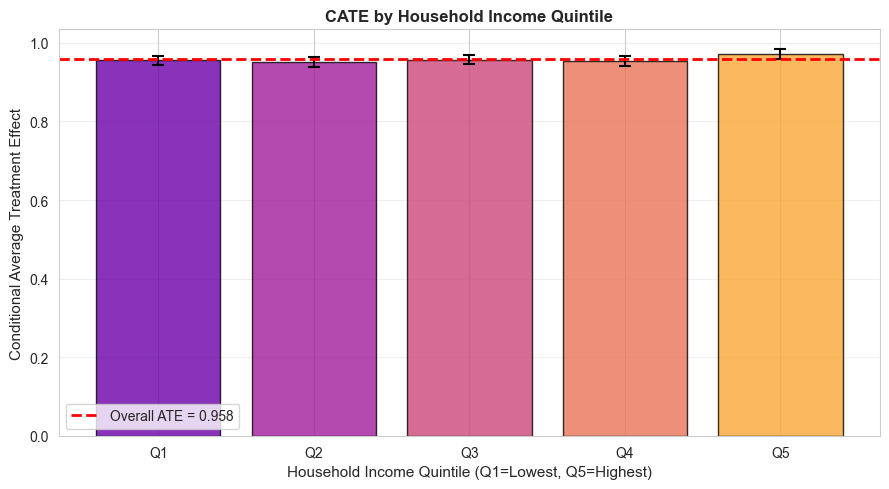

In [17]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(income_cate)))
bars = ax.bar(income_cate['income_quintile'], income_cate['mean'], color=colors, alpha=0.8, edgecolor='black')
ax.errorbar(income_cate['income_quintile'], income_cate['mean'], yerr=income_cate['se']*1.96,
            fmt='none', color='black', capsize=4, capthick=1.5)
ax.axhline(ate_cf, color='red', linestyle='--', linewidth=2, label=f'Overall ATE = {ate_cf:.3f}')
ax.set_xlabel('Household Income Quintile (Q1=Lowest, Q5=Highest)', fontsize=11)
ax.set_ylabel('Conditional Average Treatment Effect', fontsize=11)
ax.set_title('CATE by Household Income Quintile', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('cate_by_income.png', bbox_inches='tight')
plt.show()

In [18]:
results = {
    'double_lasso': {
        'ate': float(ate_dl),
        'se': float(se_dl),
        'ci_lower': float(ci_lower_dl),
        'ci_upper': float(ci_upper_dl),
        'folds': [float(x) for x in folds_dl]
    },
    'causal_forest': {
        'ate': float(ate_cf),
        'ci_lower': float(ci_cf[0]),
        'ci_upper': float(ci_cf[1]),
        'cate_min': float(cate.min()),
        'cate_max': float(cate.max()),
        'cate_std': float(cate.std())
    },
    'region_cate': region_cate.to_dict('records'),
    'income_cate': income_cate.to_dict('records')
}

import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

print('Results saved successfully')

Results saved successfully
